Data visualization with Polars and Seaborn

I love trying out new tools for processing and analyzing data. #Polars is a new data manipulation library whose main pitch as an alternative to #Pandas is speed and ease of use. Polars achieves this through query optimization, lazy loading and distributed/parallel processing. For cases when one is processing hundrends of gigabytes of data in memory, it is the way to go. The data I will be working on here is far from large. So, why would I prefer polars? For me its the expressive and intuitive syntax. One of the things that made me struggle with pandas is the frequent indexing and re-indexing of a dataframe while transforming data. Pivoting too. There is atleast two ways to do column selection and row filtering. Polars provides a cleaner interface which adheres to the #TidyData principles widely adopted within the R ecosystem. Polars also offers piping of steps out of the box with feels more natural when transforming data.

For visualization, I went for the seaborn's object interface as it offers a declarative syntax. This sytnax is easier for specifying and initializing plot properties, configurations and customizations. It follows the `Grammar of Graphics` concept in building visualizations implemented through `ggplot2` in `R`. I tried `matplotlib` too to demonstrate how it works with Polars.

For environment configuration and package management I adopted the `uv` package manager. Like #Polars, it is rust based and thus extremely fast. `uv` provides convenient tools for managing environments, command-line interfaces and running scripts. The `uv` package manager can set up by following instruction here(google.com). 
To create an environment run `uv venv`. Packages can be easily installed by running `uv pip install <package_name>`. This creates a directory named `.venv` 

My aim here is to demonstrate how easy and powerful Polars and seaborn can get for data analysis. The code snippets below are self-explanatory, thanks to Polars' clean API. If one is coming from Pandas they will definitely not struggle. If one is new to Pandas, then the Polars Official Documentation is the best place to start.


To kick-off, load the #Polars library and the data that we will explore. The data is extracted from the Kenya National Bureau of Statistics survey of the economy for the year 2023. The data is well structured as is but requires some pre-processing in order to bring it into shape for aggregation and visualization. This offers a perfect opportunity to demonstrate the data manipulation capabilities of #Polars. Many of the functions in #Polars have a match in #Pandas which makes the library easier to adopt for someone coming from #Pandas. To load `.xlsx` files in Pandas we would call `pd.read_excel()` method. In #Polars we would call `pl.read_excel()`. Calling the `.head(n)` method returns the top `n` rows in the dataframe.

In [1]:
import polars as pl

gdp = pl.read_excel(source='survey_2024.xlsx',sheet_name='Table 2.1',has_header=False)
gdp.head(5)

column_1,column_2,column_3,column_4,column_5,column_6
str,i64,i64,i64,str,str
"""Table 2.1: Gross Domestic Prod…",null,null,null,null,null
null,null,null,null,null,"""Current Prices, KSh Million"""
"""Industry""",2019,2020,2021,"""2022+""","""2023*"""
"""Agriculture, forestry and fish…",2135709,2432613,2583190,"""2837707""","""3295224"""
"""Growing of crops""",1542584,1786518,1844730,"""2016699""","""2330344"""


The data as is not ready for analysis. The columns need to be explicitly set by extracting them from a row as follows.

In [2]:
colnames_dict = gdp.filter(
    pl.col('column_1') == 'Industry'
).to_dicts()[0]

colnames = list(colnames_dict.values())
colnames


['Industry', 2019, 2020, 2021, '2022+', '2023*']

Column interactions are initialized by calling `pl.col('colname')`. The existing columns can be renamed by passing a dictionary of mapping from the old column names to the new columns names. Column selectors enable targeting of specific columns based on their types. To provide easier filtering of data using row numbers call`.with_row_index()` on a dataframe.It adds a row number for each row. The resulting dataframe is tidy and ready for further manipulation or visualization. Operations are piped by embedding code in brackets.

In [3]:
import polars.selectors as cs

gdp = (
        gdp.rename(
            {old: str(new) for old, new in zip(gdp.columns,colnames)})
            .drop_nulls()
            .with_row_index()   
            .filter(pl.col('index') > 0)
            .cast({cs.by_name('2022+','2023*'): pl.Int64})
)
gdp.head(5)

index,Industry,2019,2020,2021,2022+,2023*
u32,str,i64,i64,i64,i64,i64
1,"""Agriculture, forestry and fish…",2135709,2432613,2583190,2837707,3295224
2,"""Growing of crops""",1542584,1786518,1844730,2016699,2330344
3,"""Animal production""",354712,384578,431700,466882,570127
4,"""Support activities to agricult…",24236,25385,27022,26894,27941
5,"""Forestry & logging""",156606,172958,199012,242895,277433


Since the data is hierarchically arranged, one can extract the top economic sectors by production by manual filtering the rows

In [4]:
top_sectors = (
    gdp.filter(
        pl.col('index').is_in([1,8,13,14,15,23,26])
    )
    .drop('index')
)
top_sectors

Industry,2019,2020,2021,2022+,2023*
str,i64,i64,i64,i64,i64
"""Agriculture, forestry and fish…",2135709,2432613,2583190,2837707,3295224
"""Manufacturing""",809253,814328,885633,1044191,1148863
"""Construction""",630653,750153,849377,953773,1003964
"""Wholesale and retail trade; re…",837918,867574,952902,1042444,1134253
"""Transportation and storage""",1202830,1156921,1391614,1774470,2058336
"""Financial and insurance activi…",667702,723059,860626,1000605,1180407
"""Real estate""",946732,996203,1076597,1148722,1265366


Polars does not stop at manipulation. It provides plotting capabilities through the `plot` module built on top of the `Altair` data visualization library. To create a grouped line chart of the annual production of each sector transform the data to a longer format so that the implicit grouping variable is the `Industry` column . One can also add more columns to a dataframe with the `.with_columns()` method as shown below. In contrast to `.head(5)`, `.tail(5)` returns bottom 5 rows in the dataframe.

In [5]:
top_sectors_long = (
    top_sectors
    .unpivot(index='Industry')
    .rename(
        {   
            'variable': 'year',
            'Industry': 'industry',
            'value': 'gdp_ksh'
        }
    )
    .with_columns(
        gdp_usd = (pl.col('gdp_ksh') * 1 / (129 / 0.001)).round(2)
    )
    .sort('gdp_usd')
)
top_sectors_long.tail(10)

industry,year,gdp_ksh,gdp_usd
str,str,i64,f64
"""Transportation and storage""","""2019""",1202830,9.32
"""Real estate""","""2023*""",1265366,9.81
"""Transportation and storage""","""2021""",1391614,10.79
"""Transportation and storage""","""2022+""",1774470,13.76
"""Transportation and storage""","""2023*""",2058336,15.96
"""Agriculture, forestry and fish…","""2019""",2135709,16.56
"""Agriculture, forestry and fish…","""2020""",2432613,18.86
"""Agriculture, forestry and fish…","""2021""",2583190,20.02
"""Agriculture, forestry and fish…","""2022+""",2837707,22.0


In [6]:
(
    top_sectors_long.plot.line(x='year',y='gdp_usd',color='industry')
    .properties(width=500,height=300,title='GDP by activity')
)

alt.Chart(...)

This plot is impressive but does not lend itself to much further customization. `seaborn`'s `object` interface provides a wide range of options for that. We initialize a plot object which creates 2D object on which we can declaratively add layers of aesthetic mappings using `so.Mark` objects like `so.Dot `for scatter plots and `so.Line` for line plots. 

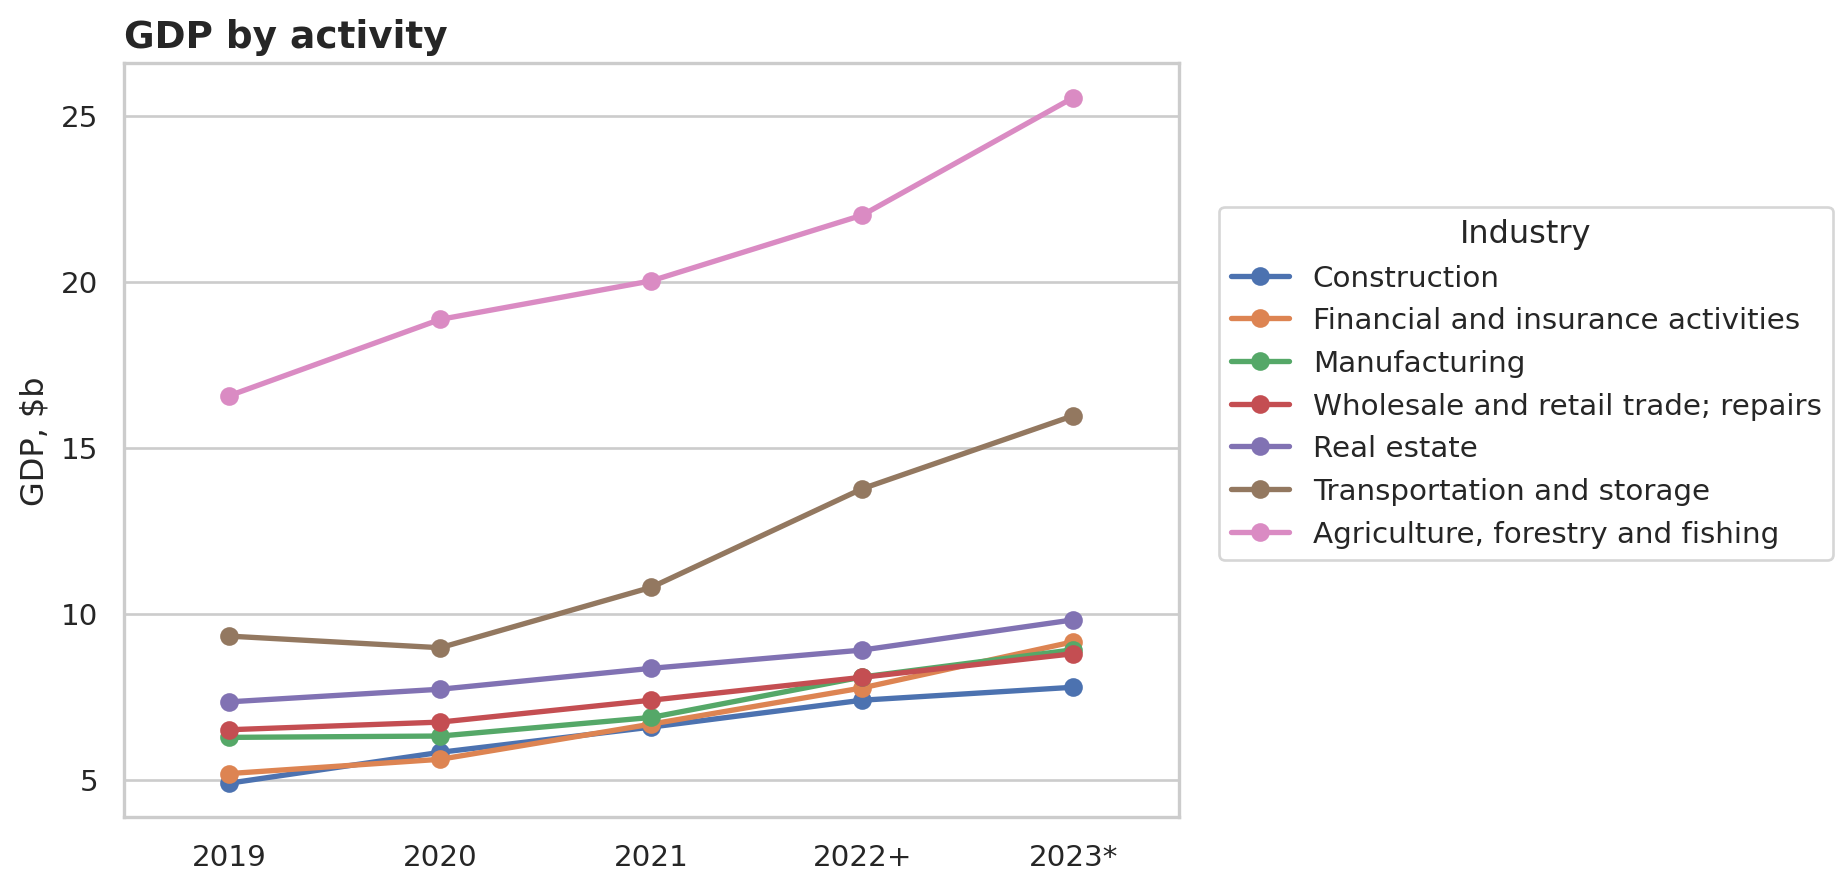

In [7]:
import seaborn.objects as so
from seaborn import axes_style

custom_theme = {**axes_style('whitegrid'),
                'axes.titleweight': 'bold',
                'axes.titlesize':14,
                'axes.titlelocation':'left'}

(
    so.Plot(top_sectors_long,'year','gdp_usd',color='industry')
    .add(so.Line(marker='o',linewidth=2,linestyle='-'))
    .label(
        x='',
        y='GDP, $b',
        title='GDP by activity',
        color=str.capitalize,
        title_fontsize=16)
    .theme(custom_theme)
)

Many plotting libraries are built on top of matplotlib. `matplotlib` integrates well with `Polars`. The is demonstrated by visualizig the annual production value and national income. However, it only accepts an `ArrayLike` object as an argument. One would need to call `.to_series()` on a dataframe column to return a pl.Series object.This is very intuitive and easy to follow through in `Polars`

In [8]:
gdp_gni = pl.read_excel('survey_2024.xlsx',sheet_name='Table 2.13',has_header=False)

colnames_gdp_gni = (
    gdp_gni.with_row_index()
    .filter(pl.col('index') ==2)
    .drop('index')
    .to_dicts()[0]
    )

colnames_gdp_gni = [str(colname).replace('.0','') for _, colname in colnames_gdp_gni.items()]
colnames_gdp_gni[0] = 'gdp_var'

gdp_income = (
    gdp_gni.rename({
        old_name: new_name for old_name,new_name in zip(gdp_gni.columns,colnames_gdp_gni)
        })
        .drop_nulls()
        .with_row_index(offset=1)
        .filter(
            pl.col('index').is_in([5,8,11])
        )
        .cast({cs.exclude('gdp_var'): pl.Int64})
)

gdp_income_long = (
    gdp_income
    .drop('index')
    .unpivot(index='gdp_var',variable_name='year',value_name='value_ksh')
    .with_columns(
        value_usd = (pl.col('value_ksh') * 1 / (129 / .001)).round(2)
    )
)
gdp_income_long

gdp_var,year,value_ksh,value_usd
str,str,i64,f64
"""Gross Domestic Product At Mark…","""2019""",10237727,79.36
"""Gross National Income At Marke…","""2019""",10074051,78.09
"""Gross National Disposable Inco…","""2019""",10612934,82.27
"""Gross Domestic Product At Mark…","""2020+""",10715070,83.06
"""Gross National Income At Marke…","""2020+""",10643131,82.5
…,…,…,…
"""Gross National Income At Marke…","""2022+""",13282228,102.96
"""Gross National Disposable Inco…","""2022+""",14050988,108.92
"""Gross Domestic Product At Mark…","""2023*""",15108806,117.12


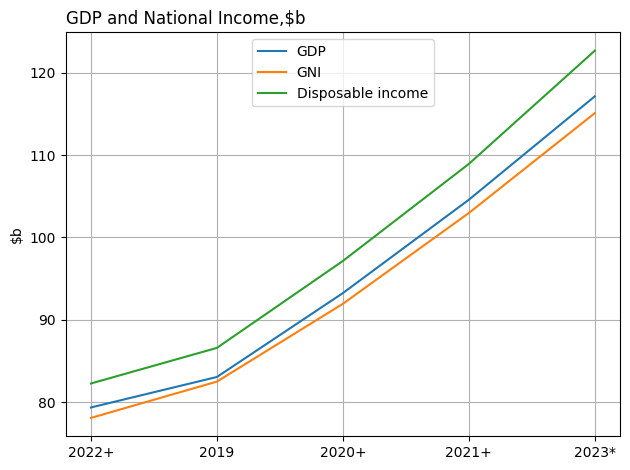

In [9]:
import matplotlib.pyplot as plt

year = gdp_income_long.select(pl.col('year')).unique().to_series()
gdp_column = gdp_income_long.filter(pl.col('gdp_var') =='Gross Domestic Product At Market Prices').select(pl.col('value_usd')).to_series()
income_column = gdp_income_long.filter(pl.col('gdp_var') == 'Gross National Income At Market Prices').select(pl.col('value_usd')).to_series()
disposable_income_column = gdp_income_long.filter(pl.col('gdp_var') == 'Gross National Disposable Income').select(pl.col('value_usd')).to_series()

plt.plot(year,gdp_column,label='GDP')
plt.plot(year,income_column,label='GNI')
plt.plot(year,disposable_income_column,label='Disposable income')

plt.legend(loc='upper center')
plt.title('GDP and National Income,$b',loc='left')
plt.ylabel('$b')
plt.tight_layout()
plt.grid()


To further explore the how convenient the oject interface is one can visualize the sectoral distribution of employment by a bar chart. Plot customization is more natural and powerful as well withe the `seaborn.objects` interface.

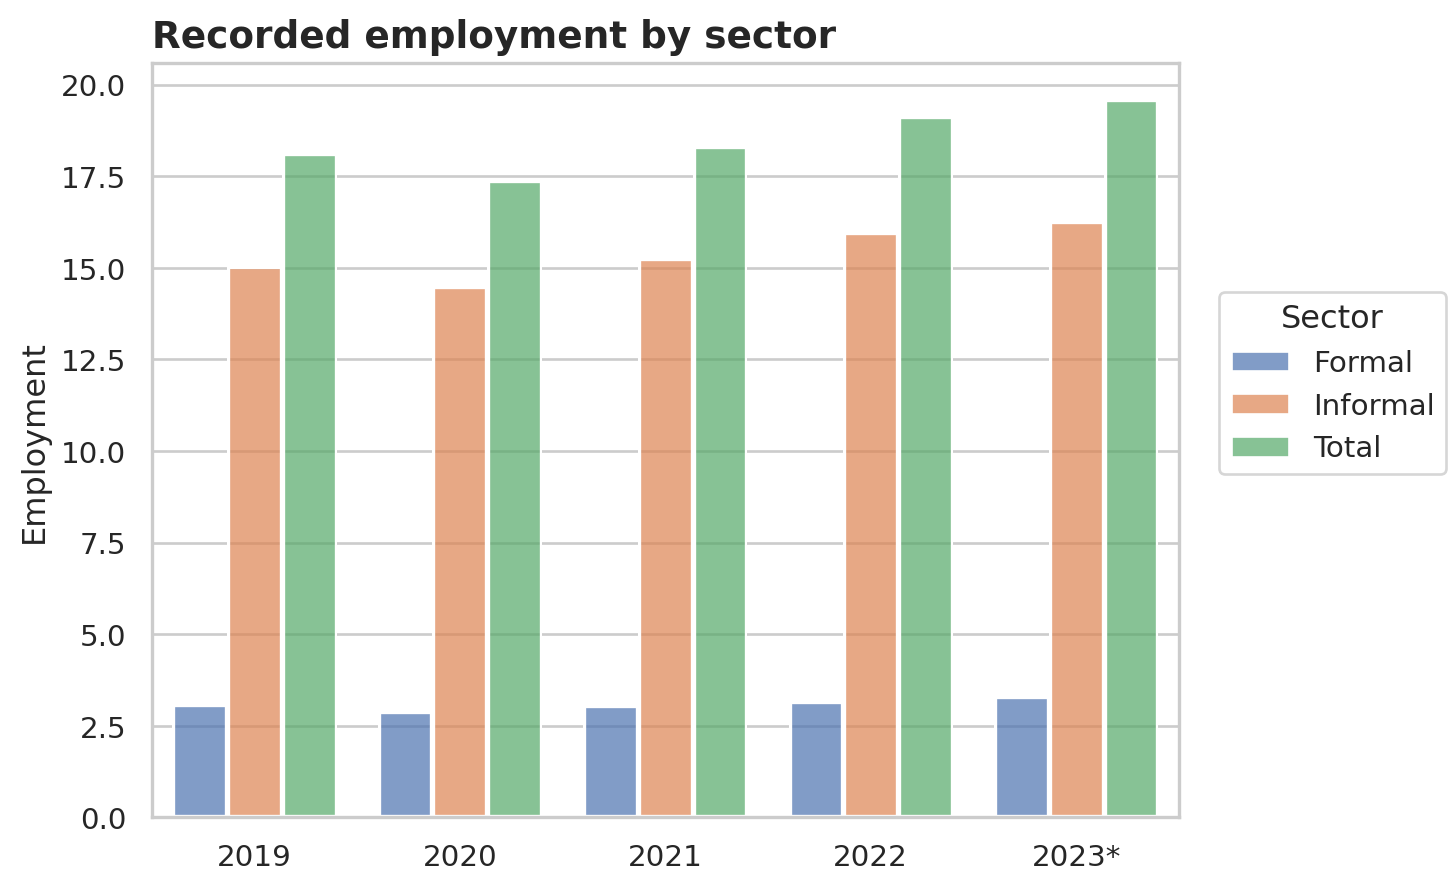

In [10]:
employment = pl.read_excel('employment_19_23.xlsx',sheet_name='Table 3.1',has_header=False)

employment_cols_dict = (
    employment
    .with_row_index()
    .filter(pl.col('index') == 2)
    .drop('index')
    .to_dicts()[0]
)

employment_cols = list(employment_cols_dict.values())
employment_cols[0] = 'sector'

employment_long = (
    employment
    .rename(
        {old:str(new) for old, new in zip(employment.columns,employment_cols)}
    )
    .drop_nulls()
    .with_row_index()
    .filter(
        pl.col('index') > 1
    )
    .with_columns(
        pl.Series(['Formal','Informal','Total']).alias('sector'),
        pl.col('2023*').cast(pl.Float64)
    )
    .drop('index')
    .unpivot(index='sector',variable_name='year',value_name='employment')
    .with_columns(
        pl.col('year').str.replace('.0','',literal=True),
        employment = pl.col('employment') / 1e3
    )
)

(
    so.Plot(employment_long,'year','employment',color='sector')
    .add(so.Bar(edgecolor='white'),so.Dodge())
    .label(x ='',y='Employment',title='Recorded employment by sector',color=str.capitalize)
    .theme(custom_theme)
)

Polars expressive syntax and intuitive interface is quite a charm. It streamlines data manipulation and facilitates data visualization by providing integration with other opinionated visualization libraries not covered here like `plotly` and `altair`. Its fast and efficient in vis a vis CPU resource utilization. This is why I am also switching to Polars.